# Welcome to the GNN-Playground! 

This interactive notebook lets you explore Graph Neural Networks (GNNs) on tiny, cpu-friendly datasets.

---

**What you can explore:**
1. **Configure** your experiment using interactive widgets. 
2. **Run** the training loop to see live updating loss and accuracy plots. 
3. **Compare** previous and current configurations side-by-side and inspect final metrics.
4. **Generate** your __official__ GNN training certificate, to summarize all your training runs, honoring your final models and experiences you gained! 
5. **Share** your certificates in our Discussion Section on GitHub to get registered on our Playground Leaderboard!

---

Are you ready? Then **Set up your model** and hit `Run All` to get started!

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Add project root to path for local imports
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

from utils.data import load_node_dataset, load_graph_dataset

seed = 42

### DATA

<div class="alert alert-block alert-info">
<b>KarateClub</b> 
Zachary (1977) recorded 34 karate club members social ties as it split due to some dispute. 
The resulting graph has 78 edges denoting friendships and community labels for the members, two groups around Mr. Hi (index 0) and John A (index 33).
KarateClub is an established Benchmark dataset and provides train/test masks for community detection.
</div>

<div class="alert alert-block alert-info">
<b>MUTAG</b> 
Debnath et al. (1977) collected 188 chemicals tested for mutagenicity. Our GNN is supposed to learn the underlying relationship between structure and activity of the compounds. Its a graph-classification benchmark with nodes representing atoms and edges representing chemical bonds.
</div>

Random seed at 42
=== Karate Club Graph ===
Number of nodes: 34
Number of edges: 78
Selected member IDs: [33]


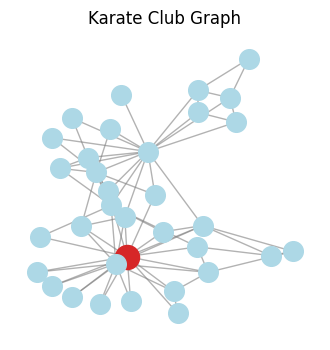

In [2]:
# Load the Karate Club dataset
# Reference: https://doi.org/10.1086/jar.33.4.3629752
karate = load_node_dataset("KarateClub", seed=seed)
# one-graph DataLoader
karate_loader = DataLoader([karate], batch_size=1, shuffle=False)
G_karate = to_networkx(karate, to_undirected=True)

samples = [33]   # <- Choose members to highlight here

# Display data
print("=== Karate Club Graph ===")
print(f"Number of nodes: {G_karate.number_of_nodes()}")
print(f"Number of edges: {G_karate.number_of_edges()}")
print(f"Selected member IDs: {samples}")

# Viz graph 

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G_karate, seed=seed)

nx.draw_networkx_nodes(
    G_karate, pos, 
    nodelist=samples,          
    node_color='tab:red', 
    node_size=300
    )
nx.draw_networkx_nodes(
    G_karate, pos, 
    nodelist=[n for n in G_karate.nodes if n not in samples],
    node_color='lightblue',
    node_size=200
    )
nx.draw_networkx_edges(
    G_karate, pos,
    edge_color='gray',
    alpha=0.6
    )
plt.title("Karate Club Graph")
plt.axis('off')
plt.show()

=== Molecule Graph ===
Number nodes: 17
Number edges: 38
Graph label y: 1
Node feature matrix shape: torch.Size([17, 7])
Edge attribute shape: torch.Size([38, 4])
Selected atom IDs: [0]


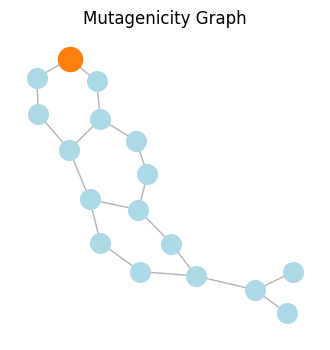

In [3]:
# Now load the Chemical Mutagenicity dataset
# Reference: https://doi.org/10.1021/jm00106a046
mutag_train_loader, mutag_test_loader = load_graph_dataset("MUTAG", batch_size=1, shuffle=False)
mutag_sample = next(iter(mutag_train_loader))
G_mutag = to_networkx(mutag_sample, to_undirected=True)

highlight_atoms = [0]  # <- Choose atoms to highlight here

# Display data
print("=== Molecule Graph ===")
print(f"Number nodes: {mutag_sample.num_nodes}")
print(f"Number edges: {mutag_sample.num_edges}")
print(f"Graph label y: {mutag_sample.y.item()}")
print(f"Node feature matrix shape: {mutag_sample.x.size()}")
print(f"Edge attribute shape: {mutag_sample.edge_attr.size()}")
print(f"Selected atom IDs: {highlight_atoms}")

# Viz graph 

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G_mutag, seed=seed)
nx.draw_networkx_nodes(
    G_mutag, pos,
    nodelist=highlight_atoms,
    node_color='tab:orange',
    node_size=300
    )
nx.draw_networkx_nodes(
    G_mutag, pos,
    nodelist=[n for n in G_mutag.nodes if n not in highlight_atoms],
    node_color='lightblue',
    node_size=200
    )
nx.draw_networkx_edges(
    G_mutag, pos,
    edge_color='gray',
    alpha=0.6
    )
plt.title("Mutagenicity Graph")
plt.axis('off')
plt.show()

### TRAINING EXAMPLE

In [4]:
from models.net import GNNModel
from utils.train import train_model

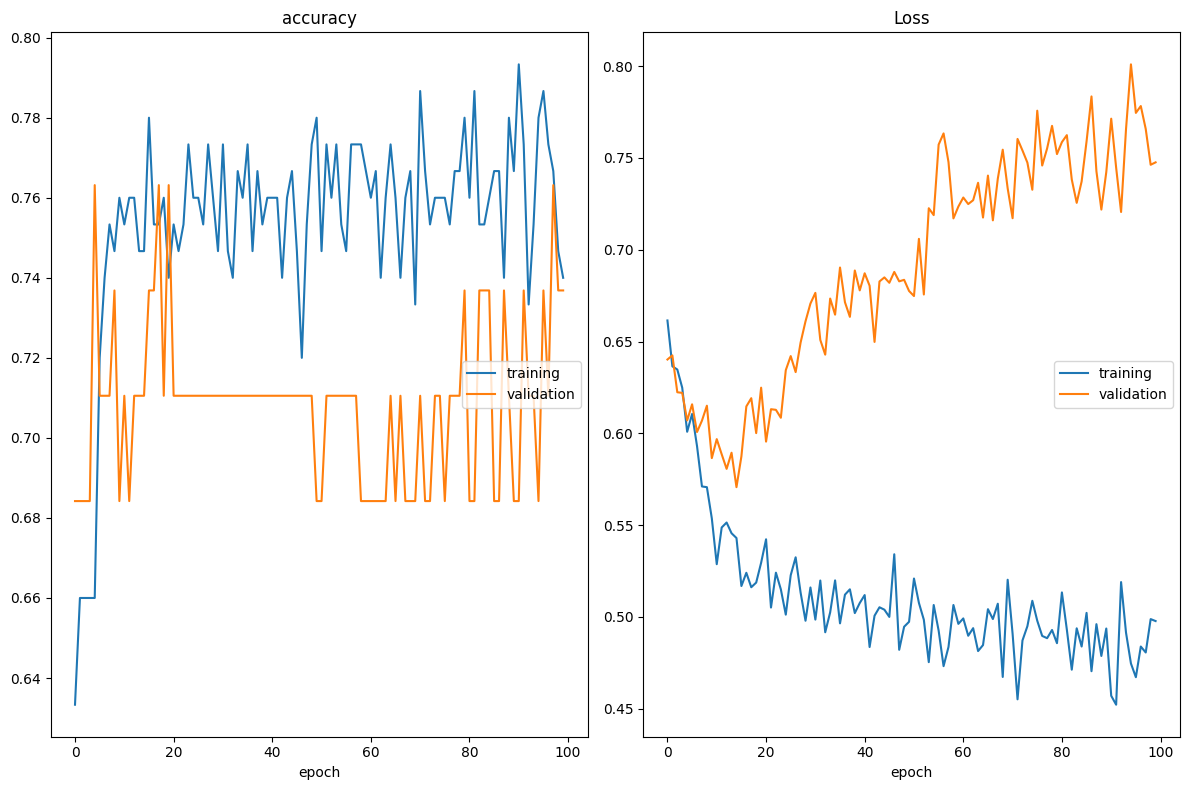

Epoch 101/100, Loss: 0.4977, Accuracy: 0.7400, Val Loss: 0.7476, Val Accuracy: 0.7368


In [5]:
mutag_model = GNNModel(
    in_dim=mutag_sample.x.size(1),
    out_dim=int(mutag_sample.y.numel()), # number of classes
    hidden_dim=128,
    num_layers=3,
    layer_type="GCN",
    dropout_value=0.5,
    glob_pooler="mean",
    task="graph",
)

history_mutag = train_model(
    model=mutag_model,
    train_loader=mutag_train_loader,
    val_loader=mutag_test_loader,
    )


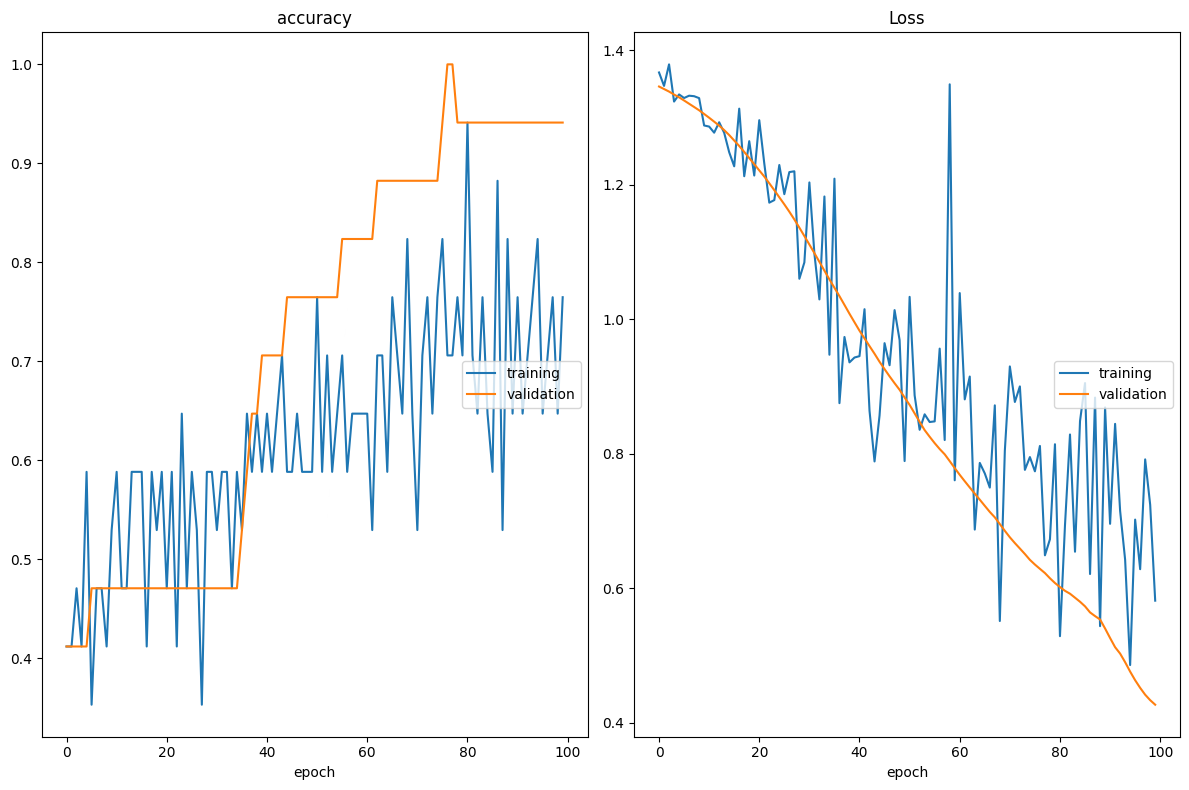

Epoch 101/100, Loss: 0.5815, Accuracy: 0.7647, Val Loss: 0.4267, Val Accuracy: 0.9412


In [6]:
karate_model = GNNModel(
    in_dim=karate.num_node_features,    # 32 one-hots
    hidden_dim=128,
    out_dim=int(karate.y.max().item()) + 1,  # number of classes
    num_layers=3,
    layer_type="GAT",
    dropout_value=0.5,
    glob_pooler="mean",
    task="node",
)

history_karate = train_model(
    model=karate_model,
    train_loader=karate_loader, 
    val_loader=karate_loader,   # same graph, metrics split by node-masks
)

### Config 

In [7]:
from utils.config import load_config

In [8]:
# 1) Load and inspect the configurations

config = load_config("../configs/example.yaml")
# Display config summary
print(f"""\
    === Config Summary ===
    Dataset:   {config["data"]["name"]}, {config["data"]["task"]}-level
    Model:     {config['model']['layer_type']} x {config['model']['num_layers']}, {config['model']['hidden_dim']} hidden dim, {config['model']['glob_pooler']} pooling
    Optimizer: {config['optimizer']['type']} at lr={config['optimizer']['lr']}, weight decay={config['optimizer']['weight_decay']}
    Training:  {config['training']['epochs']} epochs, batch size={config['training']['batch_size']}, validation split={config['training']['val_split']}
    Seed:      {config['data']['random_seed']}
    """)

    === Config Summary ===
    Dataset:   KarateClub, node-level
    Model:     GIN x 3, 64 hidden dim, sum pooling
    Optimizer: Adam at lr=0.001, weight decay=0.0001
    Training:  20 epochs, batch size=32, validation split=0.5
    Seed:      42
    


In [9]:
# 2) Instantialte loaders 

if config["data"]["task"] == "node":
    data = load_node_dataset(
        name=config["data"]["name"],
        seed=config["data"]["random_seed"],
        root="data/"
    )
    train_loader = DataLoader([data], batch_size=config["training"]["batch_size"], shuffle=False)
    val_loader = DataLoader([data], batch_size=config["training"]["batch_size"], shuffle=False) # same graph, metrics split by node-masks
else: # graph-level task
    train_loader, val_loader = load_graph_dataset(
        name=config["data"]["name"],
        root="data/",
        split_ratio=config["training"]["val_split"],
        batch_size=config["training"]["batch_size"],
        shuffle=False,
        seed=config["data"]["random_seed"]
    )

# 3) Check they are complete
print(f"TAsk: {config['data']['task']}")
print(f"Train_loader: {len(train_loader)} batches")
print(f"Val_loader: {len(val_loader)} batches")

Random seed at 42
TAsk: node
Train_loader: 1 batches
Val_loader: 1 batches
